# Title


### Class def

In [1]:
import pyvisa
import time

class RigolInstrument:
    def __init__(self, resource_name):
        self.inst = pyvisa.ResourceManager().open_resource(resource_name)
        self.inst.timeout = 5000
        self.inst.encoding = 'utf-8'
        self.idn = self.get_idn()
        self.instrument_type = self.classify_instrument()

    def get_idn(self):
        try:
            self.inst.write('*IDN?')
            time.sleep(0.1)
            return self.inst.read().strip()
        except pyvisa.errors.VisaIOError:
            return "Unknown"

    def getter_idn(self):
        return self.idn

    def classify_instrument(self):
        idn_upper = self.idn.upper()
        if "RIGOL" in idn_upper and "DG" in idn_upper:
            return "generator"
        elif "RIGOL" in idn_upper and ("DS" in idn_upper or "MSO" in idn_upper):
            return "oscilloscope"
        else:
            return "unknown"

    def write(self, command):
        self.inst.write(command)

    def query(self, command):
        return self.inst.query(command)
        
    def read(self):
        return self.inst.read()

    def close(self):
        self.inst.close()
    
    def __str__(self):
        return f"{self.instrument_type.capitalize()} - IDN: {self.idn}"

    def toggle(channel, state, self):
        # ------ CH1 ----------
        if channel == "CH1":
            if state == "ON":
                self.write("OUTP1 ON")
            else:
                self.write("OUTP1 OFF")
        # ------ CH2 ----------
        elif channel == "CH2":
            if state == "ON":
                self.write('OUTP:CH2 ON ')
            else:
                self.write('OUTP:CH2 OFF ')
        return

    def generate_waveform(self, channel, waveform_type, frequency, amplitude, offset=0, phase=0, duty_cycle=50):
        """Note that writing to CH1 is different from writing to CH2...."""
        args = f"{frequency}, {amplitude}, {offset} "
        
        if channel == "CH1":
            # print(channel)
            self.write('VOLT:UNIT VPP')
            time.sleep(0.05)
            self.write(f'APPL:{waveform_type} {args}')   # e.g. APPL:RAMP 1000, 2.5, 0.5
            time.sleep(0.05)
            self.write(f'PHAS {phase} ')
            time.sleep(0.05)
            self.write("OUTP1 ON")
            # self.toggle("CH1", "ON", self)

        else:
            # for CH2 use the CH-specific notation...
            self.write(f'VOLT:UNIT:{channel} VPP')
            time.sleep(0.05)
            self.write(f'APPL:{waveform_type}:{channel} {args}')  # e.g. APPL:SQUare:CH2 1000, 2.5, 0.5
            time.sleep(0.05)
            self.write(f'PHAS:{channel} {phase} ')
            time.sleep(0.05)
            self.write('OUTP:CH2 ON ')
            # self.toggle(f"CH2", "ON", self)



def detect_rigol_instruments():
    """Retourne un tuple (generator, oscilloscope) si présents, sinon None."""
    rm = pyvisa.ResourceManager()
    devices = [d for d in rm.list_resources() if "USB" in d]
    print(f"Devices : {devices}")

    generator = None
    oscilloscope = None
    print("Detecting Rigol instruments...")

    for dev in devices:
        rigol = RigolInstrument(dev)
        if rigol.instrument_type == "generator":
            generator = rigol
            print(f"Detected Generator: {generator}")
        elif rigol.instrument_type == "oscilloscope":
            oscilloscope = rigol
            print(f"Detected Oscilloscope: {oscilloscope}")

    return generator, oscilloscope


generator, oscilloscope = detect_rigol_instruments()

if generator:
    generator.close()
else:
    print("No generator detected.")

if oscilloscope:
    oscilloscope.close()
else:
    print("No oscilloscope detected.")



Devices : ['USB0::0x1AB1::0x04CE::DS1ZC212301115::INSTR', 'USB0::0x0400::0x09C4::DG1F143800627::INSTR']
Detecting Rigol instruments...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022A,DG1F143800627,,00.03.00.08.00.01.02


### Rigol DG1022 :


In [2]:


# 1 - Connect to DG1022Z (and DS1054Z)
generator, oscilloscope = detect_rigol_instruments()




# 2 - Toggle CH1, CH2
if False:
    t =2
    generator.write("OUTP1 ON")
    time.sleep(t)
    generator.write("OUTP1 OFF")
    time.sleep(t)
    generator.write('OUTP:CH2 ON ')
    time.sleep(t)
    generator.write('OUTP:CH2 OFF')
    time.sleep(t)

# ! DOESNT WORK ?
# if True:
#     t = 2
#     generator.toggle("CH1", "ON")
#     time.sleep(t)
#     generator.toggle("CH1", "OFF")
#     time.sleep(t)
#     generator.toggle("CH2", "ON")
#     time.sleep(t)
#     generator.toggle("CH2", "OFF")
#     time.sleep(t)

# 3 - Sine Function
wave = {
    "sin":"SINusoid",
    "square" : "SQUare",
    "ramp" : "RAMP",
    "pulse" : "PULSe",
    "noise" : "NOISe",
    "dc" : "DC"
}
if False:
    for w in wave:
        generator.generate_waveform(channel="CH1", waveform_type=w, frequency=1000, amplitude=5)
        print(f'CH1 is a : {w}')
        time.sleep(2)

    for w in wave:
        generator.generate_waveform(channel="CH2", waveform_type=w, frequency=1000, amplitude=5)
        print(f'CH2 is a : {w}')
        time.sleep(2)

# generator.generate_waveform(channel="CH1", waveform_type="DC", frequency=1000, amplitude=5)


generator.close()
oscilloscope.close()




Devices : ['USB0::0x1AB1::0x04CE::DS1ZC212301115::INSTR', 'USB0::0x0400::0x09C4::DG1F143800627::INSTR']
Detecting Rigol instruments...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022A,DG1F143800627,,00.03.00.08.00.01.02


### 4 - Exponential Wave Flattening by capacitor:

In [14]:
# 4.On a breadboard, use a capacitor to flatten an exponential wave generated by the generator
#  (find the right information in the manual). Watch your signal on the oscilloscope.


### 6 - Record and Save in CSV:

In [ ]:
# . Record all the information of exercise 5 in a CSV file with a timeline and show it with a
#  graph

### 7 - (Challenge) Generate song into Speaker:

In [ ]:
# 7. Challenge : Use a song as an arbitrary waveform and make it generated by the generator
#  into the speaker. (ask the speaker to the professors)

---
## Session 2- the Oscilloscope-DS1104 :

### DS1104 - Z Plus

In [ ]:
# 1 - Connect to DG1022Z (and DS1054Z)
generator, oscilloscope = detect_rigol_instruments()



generator.close()
oscilloscope.close()

### 2 - Oscilloscope:

Create a program that can interface the oscilloscope and plot VRMS as a function of 
- (a) Use numpy
- (b) use Use MatplotLib (Some people may encounter an error of "non interactive plot", in this case, you can install pyQT5 (or higher)  with the line pip install pyqt5)



In [2]:
import numpy as np
import matplotlib.pyplot as plt

def measure_vrms(ds, channel='CH1'):
    """Get a single VRMS measurement from the scope."""
    ds.write(f':MEAS:SOUR {channel}')
    time.sleep(0.05)
    result = ds.query(':MEAS:ITEM? VRMS')
    return float(result.strip())

def plot_vrms(times, values, title="VRMS vs Time", show_average=True):
    """Plot VRMS data with optional average line."""
    plt.figure(figsize=(10, 5))
    plt.plot(times, values, 'o-', label='VRMS samples')
    
    if show_average:
        avg = np.nanmean(values)
        plt.axhline(avg, color='r', linestyle='--', label=f'Average: {avg:.6f} V')
    
    plt.xlabel('Time (s)')
    plt.ylabel('VRMS (V)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [5]:
# Connect Oscilloscope and Function Generator
generator, oscilloscope = detect_rigol_instruments()

if False:
    if oscilloscope and generator:
        # Generate DC with Ampl=5V on CH1
            # Waves : (sin, square, ramp, pulse, noise, dc)
        generator.generate_waveform(channel="CH1", waveform_type=wave["sin"], frequency=1000, amplitude=5)
        
        # time.sleep(5)

        # Measure VRMS
        print(measure_vrms(oscilloscope, 'CH1'))    #! Should print 1.78 V (=Vrms of 5Vpp sine wave)
        time.sleep(1)

        # Plot
        # plot_vrms()


# Close
generator.close()
oscilloscope.close()

Devices : ['USB0::0x1AB1::0x04CE::DS1ZC212301115::INSTR', 'USB0::0x0400::0x09C4::DG1F143800627::INSTR']
Detecting Rigol instruments...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022A,DG1F143800627,,00.03.00.08.00.01.02
9.9e+37


In [43]:
# 2. To measure an accurate value of the VRMS take several values of it (10 then 100), plot all
#  the value and the average of its. Don’t forget to leave some time to the data to be stored
#  (500ms per scan).

def collect_samples(ds, n_samples, wait_ms=500, channel='CHAN1'):
    """Collect n samples with specified wait time. Returns (times, values)."""
    times = []
    values = []
    start = time.time()
    print_val = []

    
    for i in range(n_samples):
        try:
            val = measure_vrms(ds, channel)
            values.append(val)
            times.append(time.time() - start)
            print_val.append(f"{val:.3f} V")
            time.sleep(wait_ms / 1000.0)
        except Exception as e:
            print(f"Sample {i+1} failed: {e}")
            values.append(np.nan)
            times.append(time.time() - start)
    print(print_val)
    return np.array(times), np.array(values)


Devices : ['USB0::0x1AB1::0x04CE::DS1ZC212301115::INSTR', 'USB0::0x0400::0x09C4::DG1F143800627::INSTR']
Detecting Rigol instruments...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022A,DG1F143800627,,00.03.00.08.00.01.02
['2.562 V', '2.562 V', '2.560 V', '2.560 V', '2.562 V', '2.563 V', '2.561 V', '2.567 V', '2.562 V', '2.562 V']


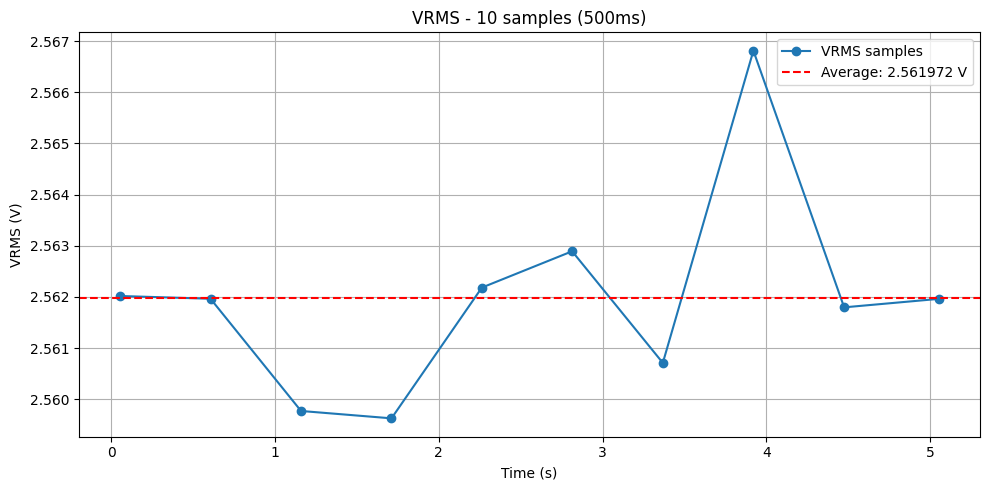

In [45]:
# Connect Oscilloscope and Function Generator
generator, oscilloscope = detect_rigol_instruments()

if False:
    if oscilloscope and generator:
        # Generate DC with Ampl=5V on CH1
        generator.generate_waveform(channel="CH1", waveform_type=wave["square"], frequency=1000, amplitude=5)  # Waves : (sin, square, ramp, pulse, noise, dc)
        time.sleep(1)

        # Collect samples and plot
        t10, v10 = collect_samples(oscilloscope, n_samples=10, wait_ms=500, channel='CHAN1')
        plot_vrms(t10, v10, title="VRMS - 10 samples (500ms)", show_average=True)

        # Close
        generator.close()
        oscilloscope.close()



In [46]:
# 3. Let’s start reducing the value of waiting. Compute the minimum waiting time and
#  with it the sampling rate of VRMS on the oscilloscope.

def find_min_delay(ds, test_delays=[500, 250, 100, 50, 25, 10, 5, 1], n_test=10, channel='CHAN1'):
    """Find minimum reliable delay between measurements. Returns (min_delay_ms, max_rate_hz)."""
    for delay_ms in test_delays:
        print(f"\nTesting {delay_ms}ms delay...")
        t_start = time.time()
        success = 0
        
        for i in range(n_test):
            try:
                measure_vrms(ds, channel)
                success += 1
                time.sleep(delay_ms / 1000.0)
            except Exception as e:
                print(f"  Failed at sample {i+1}: {e}")
                break
        
        elapsed = time.time() - t_start
        
        if success == n_test:
            rate = success / elapsed
            print(f"  ✓ SUCCESS: {success}/{n_test} in {elapsed:.3f}s → {rate:.2f} Hz")
            return delay_ms, rate
        else:
            print(f"  ✗ FAILED: {success}/{n_test} samples")
    
    return None, None


In [48]:
# Connect Oscilloscope and Function Generator
generator, oscilloscope = detect_rigol_instruments()

if False:
    if oscilloscope and generator:
        min_delay, max_rate = find_min_delay(oscilloscope, channel='CHAN1')
        if min_delay:
            print(f"\n✓ Minimum delay: {min_delay}ms")
            print(f"✓ Maximum sampling rate: {max_rate:.2f} Hz")


        # Close
        generator.close()
        oscilloscope.close()

 



Devices : ['USB0::0x1AB1::0x04CE::DS1ZC212301115::INSTR', 'USB0::0x0400::0x09C4::DG1F143800627::INSTR']
Detecting Rigol instruments...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022A,DG1F143800627,,00.03.00.08.00.01.02

Testing 500ms delay...
  ✓ SUCCESS: 10/10 in 5.640s → 1.77 Hz

✓ Minimum delay: 500ms
✓ Maximum sampling rate: 1.77 Hz


### 3 - Full Wave Measurement

Goal :
- captures and plots a raw waveform (the actual voltage samples over time) from the oscilloscope screen.

Devices : ['USB0::0x1AB1::0x04CE::DS1ZC212301115::INSTR', 'USB0::0x0400::0x09C4::DG1F143800627::INSTR']
Detecting Rigol instruments...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022A,DG1F143800627,,00.03.00.08.00.01.02
*IDN : RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Preamble: 2,0,1200,1,2.000000e-06,-1.200000e-03,0,8.000000e-01,-26,127


    Parsed Preamble:
    Format: 2 (2=ASCII)
    Points: 1200
    Count : 1
    Time/sample: 2.000 µs
    Voltage/level: 800.000 mV
    XY-origin: -0.0/-26.0 V
    
First 200 chars of raw data: #9000016201-2.639998e+01,-2.639998e+01,-2.639998e+01,-2.639998e+01,-2.639998e+01,-2.719998e+01,-2.639998e+01,-2.639998e+01,-2.639998e+01,-2.639998e+01,-2.639998e+01,-2.479998e+01,-2.639998e+01,-2.4799
Number of points: 1200


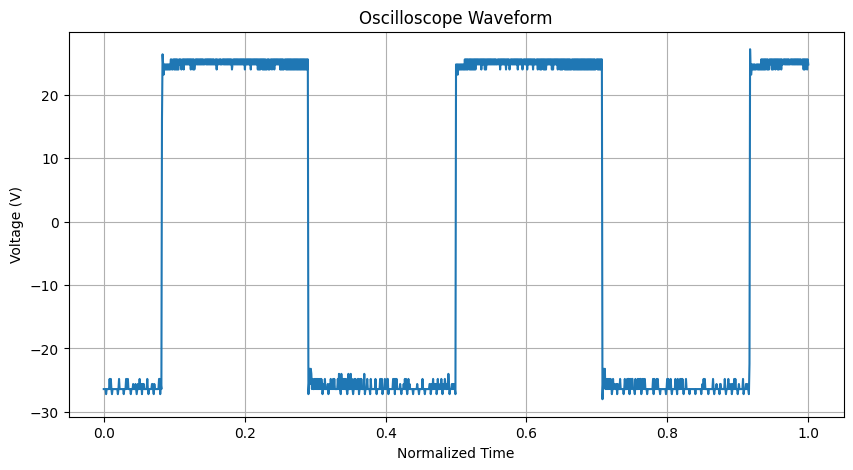

In [15]:
#  Try this code that allows you to read what you see on the oscilloscope. 
# How does it perform?

import pyvisa
import time
import numpy as n
import matplotlib.pyplot as mp

t = 2

if False:
    generator, osc = detect_rigol_instruments()
    time.sleep(3)
    print(f"*IDN : {osc.getter_idn()}")

    # reading procedure initialisation
    osc.write(':WAVeform:FORMat ASCII') #easy to read information but slower
    time.sleep(t)
    osc.write(':WAVeform:Mode NORMAL') #see programming book
    time.sleep(t)
    L1 = osc.query(':WAVeform:PREamble?') #to know everything
    time.sleep(t)
    print(L1)
    osc.write(':WAVform:SOURce Channel1')
    time.sleep(t)
    D1 = osc.query(':WAVEFORM:DATA?')
    time.sleep(t)
    D2 = D1.split(',')
    Lgth = n.size(D2)
    mp.plot(n.linspace(0,1,Lgth-1),D2[1:Lgth])




# What code could help you get a better plot of your data? 
    # Print D1 or D2, this might help you to find the answer. 
    # Hint : the ascii format is not convenient to plot your data , 
    # try to cast it into an usable one.


if False:
    print("==============================")
    generator, osc = detect_rigol_instruments()
    time.sleep(3)
    print(f"*IDN : {osc.getter_idn()}")

    time.sleep(2)

    # Ensure channel 1 is ON
    osc.write(':CHAN1:DISP ON')
    time.sleep(0.5)

    # Configure waveform capture
    osc.write(':WAV:SOUR CHAN1')
    osc.write(':WAV:MODE NORM')
    osc.write(':WAV:FORM ASC')   # send numbers instead of binary bytes

    # Get preamble (metadata)
    preamble = osc.query(':WAV:PRE?')
    print("Preamble:", preamble)
    # Parse preamble into named variables
    preamble_values = preamble.split(',')

    format_type = int(preamble_values[0])      # 0=BYTE, 1=WORD, 2=ASCII
    acq_type = int(preamble_values[1])         # 0=NORMAL, 1=AVERAGE, 2=PEAK, 3=HIGH_RES
    points = int(preamble_values[2])           # Number of waveform points
    count = int(preamble_values[3])            # Always 1 for NORMAL mode
    x_increment = float(preamble_values[4])    # Time between points (seconds)
    x_origin = float(preamble_values[5])       # Time of first point (seconds)
    x_reference = int(preamble_values[6])      # Always 0
    y_increment = float(preamble_values[7])    # Voltage per ADC level
    y_origin = float(preamble_values[8])       # Voltage at center screen
    y_reference = int(preamble_values[9])      # ADC value at center (usually 127)

    print(f"""
    Parsed Preamble:
    Format: {format_type} (2=ASCII)
    Points: {points}
    Count : {count}
    Time/sample: {x_increment*1e6:.3f} µs
    Voltage/level: {y_increment*1000:.3f} mV
    XY-origin: {x_origin:.1f}/{y_origin:.1f} V
    """)
    



    # Fetch waveform data
    raw_data = osc.query(':WAV:DATA?')
    print("First 200 chars of raw data:", raw_data[:200])

    # Parse ASCII data
    values = raw_data.split(',')
    print(f"Number of points: {len(values)}")

    # Convert to float array (skip first element if it's a header like '#')
    if values[0].startswith('#'):
        values = values[1:]

    y_data = np.array([float(v) for v in values if v.strip()])

    # Plot
    x_data = np.linspace(0, 1, len(y_data))
    plt.figure(figsize=(10, 5))
    plt.plot(x_data, y_data)
    plt.xlabel('Normalized Time')
    plt.ylabel('Voltage (V)')
    plt.title('Oscilloscope Waveform')
    plt.grid(True)
    plt.show()

    osc.close()





### 4 - Phase Measurement

Based on two identical sinusoidal signals but having a difference in phase, perform a delay and
phase measurement. 

Does it correspond to the signal generated by the rigol generator? To go
further, you can generate the signal in Python with the DG1022.

In [3]:

# Phase Measurement Exercise
import numpy as np
import matplotlib.pyplot as plt
import time

def capture_waveform(osc, channel='CHAN1'):
    """Capture waveform from specified channel. Returns (time_array, voltage_array, preamble_dict)."""
    # Configure channel and waveform capture
    osc.write(f':WAV:SOUR {channel}')
    osc.write(':WAV:MODE NORM')
    osc.write(':WAV:FORM ASC')
    
    # Get preamble
    preamble = osc.query(':WAV:PRE?')
    preamble_values = preamble.split(',')
    
    # Parse preamble
    preamble_dict = {
        'format_type': int(preamble_values[0]),
        'acq_type': int(preamble_values[1]),
        'points': int(preamble_values[2]),
        'count': int(preamble_values[3]),
        'x_increment': float(preamble_values[4]),  # seconds
        'x_origin': float(preamble_values[5]),
        'x_reference': int(preamble_values[6]),
        'y_increment': float(preamble_values[7]),
        'y_origin': float(preamble_values[8]),
        'y_reference': int(preamble_values[9])
    }
    
    # Fetch waveform data
    raw_data = osc.query(':WAV:DATA?')
    values = raw_data.split(',')
    
    # Clean header if present
    if values[0].startswith('#'):
        values = values[1:]
    
    # Convert to voltage array
    y_data = np.array([float(v) for v in values if v.strip()])
    
    # Create real time axis
    time_axis = np.arange(len(y_data)) * preamble_dict['x_increment'] + preamble_dict['x_origin']
    
    return time_axis, y_data, preamble_dict


def calculate_phase_difference(time1, signal1, time2, signal2, frequency):
    """
    Calculate phase difference between two sinusoidal signals.
    Returns (phase_deg, time_delay_us).
    """
    # Ensure same time base
    if not np.array_equal(time1, time2):
        print("Warning: Time bases don't match exactly")
    
    # Find zero crossings (rising edge)
    def find_first_rising_zero(t, sig):
        # Find where signal crosses zero going positive
        mean_val = np.mean(sig)
        centered = sig - mean_val
        
        for i in range(len(centered) - 1):
            if centered[i] <= 0 and centered[i+1] > 0:
                # Linear interpolation for exact crossing
                t_cross = t[i] - centered[i] * (t[i+1] - t[i]) / (centered[i+1] - centered[i])
                return t_cross
        return None
    
    # Find first zero crossing for each signal
    t_cross1 = find_first_rising_zero(time1, signal1)
    t_cross2 = find_first_rising_zero(time2, signal2)
    
    if t_cross1 is None or t_cross2 is None:
        print("Error: Could not find zero crossings")
        return None, None
    
    # Calculate time delay
    time_delay = abs(t_cross2 - t_cross1)  # seconds
    
    # Calculate phase difference
    period = 1.0 / frequency  # seconds
    phase_rad = (time_delay / period) * 2 * np.pi
    phase_deg = np.degrees(phase_rad) % 360
    
    return phase_deg, time_delay * 1e6  # return delay in microseconds


def plot_dual_waveforms(time1, sig1, time2, sig2, phase_deg, delay_us, freq):
    """Plot both waveforms with phase info."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot both signals overlaid
    ax1.plot(time1 * 1e6, sig1, label='CH1', alpha=0.7)
    ax1.plot(time2 * 1e6, sig2, label='CH2', alpha=0.7)
    ax1.set_xlabel('Time (µs)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_title(f'Phase Difference: {phase_deg:.2f}° | Time Delay: {delay_us:.3f} µs | Frequency: {freq/1000:.1f} kHz')
    ax1.grid(True)
    ax1.legend()
    
    # Plot zoomed section (first few periods)
    periods_to_show = 3
    t_end = periods_to_show / freq
    mask1 = time1 <= t_end
    mask2 = time2 <= t_end
    
    ax2.plot(time1[mask1] * 1e6, sig1[mask1], 'o-', label='CH1', markersize=3)
    ax2.plot(time2[mask2] * 1e6, sig2[mask2], 'o-', label='CH2', markersize=3)
    ax2.set_xlabel('Time (µs)')
    ax2.set_ylabel('Voltage (V)')
    ax2.set_title(f'Zoomed: First {periods_to_show} periods')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()



Devices : ['USB0::0x1AB1::0x04CE::DS1ZC212301115::INSTR', 'USB0::0x0400::0x09C4::DG1F143800627::INSTR']
Detecting Rigol instruments...
Detected Oscilloscope: Oscilloscope - IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301115,00.04.04.SP4
Detected Generator: Generator - IDN: RIGOL TECHNOLOGIES,DG1022A,DG1F143800627,,00.03.00.08.00.01.02

=== Generating signals ===
Frequency: 10.0 kHz
Amplitude: 2.0 Vpp
CH1 phase: 0°
CH2 phase: 45°

=== Capturing waveforms ===
CH1: 1199 points captured
CH2: 1199 points captured

=== Calculating phase difference ===
Note : The DG1022 channels are completely independent — setting CH2 phase to 45° doesn't mean "45° relative to CH1", it means "45° relative to CH2's own arbitrary start time". The two channels aren't synchronized.
For accurate phase measurements, manually introduce a phase delay (RC circuit, etc.) between channels.
Measured phase difference: 25.94°
Expected phase difference: 45°
Error: 19.06°
Time delay: 7.205 µs
Expected time delay: 12.500 µs

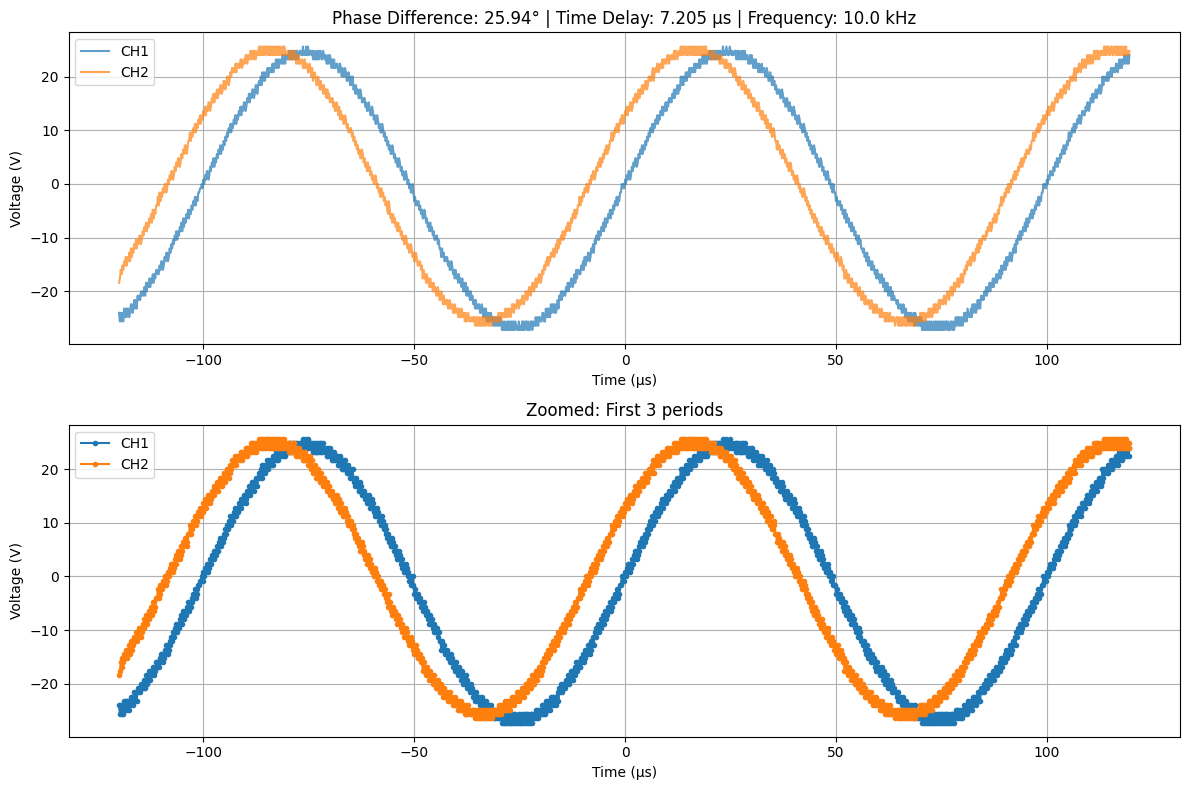

In [4]:
# ==================== MAIN EXECUTION ====================

if True:
    # Connect instruments
    generator, osc = detect_rigol_instruments()
    time.sleep(5)



    # Define test parameters
    test_frequency = 10000  # 10 kHz
    test_amplitude = 2.0    # 2V peak-to-peak
    phase_ch2 = 45          #! Set CH2 to 45° phase shift


    print(f"\n=== Generating signals ===")
    print(f"Frequency: {test_frequency/1000:.1f} kHz")
    print(f"Amplitude: {test_amplitude} Vpp")
    print(f"CH1 phase: 0°")
    print(f"CH2 phase: {phase_ch2}°")

    # Generate identical sinusoids with phase difference
    generator.generate_waveform(
        channel="CH1",
        waveform_type=wave["sin"],
        frequency=test_frequency,
        amplitude=test_amplitude,
        phase=0
    )

    time.sleep(5)

    generator.generate_waveform(
        channel="CH2",
        waveform_type=wave["sin"],
        frequency=test_frequency,
        amplitude=test_amplitude,
        phase=phase_ch2
    )


    time.sleep(2)  # Let signals stabilize

    # Capture waveforms from both channels
    print("\n=== Capturing waveforms ===")
    osc.write(':CHAN1:DISP ON')
    osc.write(':CHAN2:DISP ON')
    time.sleep(1)

    time1, signal1, preamble1 = capture_waveform(osc, 'CHAN1')
    print(f"CH1: {len(signal1)} points captured")

    time2, signal2, preamble2 = capture_waveform(osc, 'CHAN2')
    print(f"CH2: {len(signal2)} points captured")

    # Calculate phase difference
    print("\n=== Calculating phase difference ===")
    msg = "Note : The DG1022 channels are completely independent — setting CH2 phase to 45° doesn't mean \"45° relative to CH1\", it means \"45° relative to CH2's own arbitrary start time\". The two channels aren't synchronized."
    print(msg)
    print("For accurate phase measurements, manually introduce a phase delay (RC circuit, etc.) between channels.")
    phase_measured, delay_measured = calculate_phase_difference(
        time1, signal1, time2, signal2, test_frequency
    )



    if phase_measured is not None:
        print(f"Measured phase difference: {phase_measured:.2f}°")
        print(f"Expected phase difference: {phase_ch2}°")
        print(f"Error: {abs(phase_measured - phase_ch2):.2f}°")
        print(f"Time delay: {delay_measured:.3f} µs")
        
        # Verify: time_delay = phase / (360 * frequency)
        expected_delay = (phase_ch2 / 360.0) / test_frequency * 1e6  # µs
        print(f"Expected time delay: {expected_delay:.3f} µs")
        
        # Plot results
        plot_dual_waveforms(time1, signal1, time2, signal2, phase_measured, delay_measured, test_frequency)
    else:
        print("Phase measurement failed!")

    # Close connections
    generator.close()
    osc.close()




### 5 - Automated Code


 Create a generic code that generates a sinus with the DG1022 and measure it with the DS1104.
 - The measured value must be plotted with Matplotlib, in an understandable voltage and time scale.
 - The legend of the plot should have the frequency, VPP, Vmin and Vmax. 
 - At the same time, the values generated and measured have to be stored in a TXT or CSV file for later use.

---
## Session 3 : Arduino and Power Supply

### 1-Arduino:

### 2-All together:

### x-Challenge:

### x-ChallengeBis: PowerSupply

### 3-All together Bis: